# Example notebook: Loading a simulation from the Fisher dataset

Authors: Adélie Gorce & Ian Hothi

In this notebook, we give an example of how to load one of the simulation from the dataset, plot it, and compute its power spectrum.


The data has been simulated using 21cmFast. The XY plane has an extent of 250Mpc, with 256 pixels on each side. The line-of-sight (redshift) has been simulated to be between z = 8.82 (144.60 MHz) and z = 9.33 (137.46 MHz), comprising 128 frequency channels. The three parameters chosen to be changed are the virial temperature, maximum bubble size, and the ionising efficiency parameter—these were all found to have the strongest impact on the signal. 

These are the parameter variations (fiducial value $\pm$ change):

- $T_{Vir}$: $50000\pm 5000$
- $R_{Max}$: $15\pm 5 Mpc$
- $\zeta$: $30\pm 5$,
400 simulations were run for each parameter value, which will be used for the derivatives. In the loaded files, there will be two files for each parameter, one corresponding to the plus value - for example, for $T_{Vir}$ tue value would be 50000 + 5000. Whereas the minus value would be 50000 - 5000.


400 simulations were run with the fiducial values, this will serve to calculate the covariances of the statistics.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
#For Power Spectrum Calculations 
import tools21cm as t2c

In [2]:
seed = 123456 # Choose your favorite number
np.random.seed(seed)

## Load metadata and simulation

In [3]:
# Folder containing the simulations
ddir = '/data/cluster/agorce/SKA_chapter_simulations/'
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [4]:
# Read h5py file to obtain metadata
with h5py.File(file, 'r') as f:
    frequencies = f['frequencies'][...]  # frequencies along the lightcone
    redshifts = f['redshifts'][...]  # redshifts along the lightcone
    box_length = float(f['box_length'][0])  # Mpc
    ngrid = int(f['ngrid'][0])  # number of pixels along the sky patch
    nrand = int(f['nrealisations'][0])  # number of realisations for a given parameter set
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}.')

Lightcone runs from z=8.82 to z = 9.33.


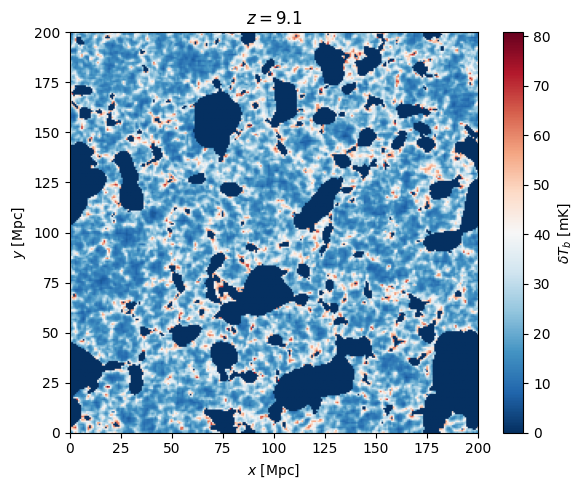

In [5]:
# Read h5py file for iz-th redshift and i-th realisation
iz = np.random.randint(nfreq)
i = np.random.randint(nrand)

with h5py.File(file, 'r') as f:
    coeval_slice = f['brightness_lightcone'][i, iz, :, :]  # Reads only (nz, n, n), not entire data

iz = 50

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    coeval_slice,
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'$z={redshifts[iz]:.1f}$')
fig.tight_layout()

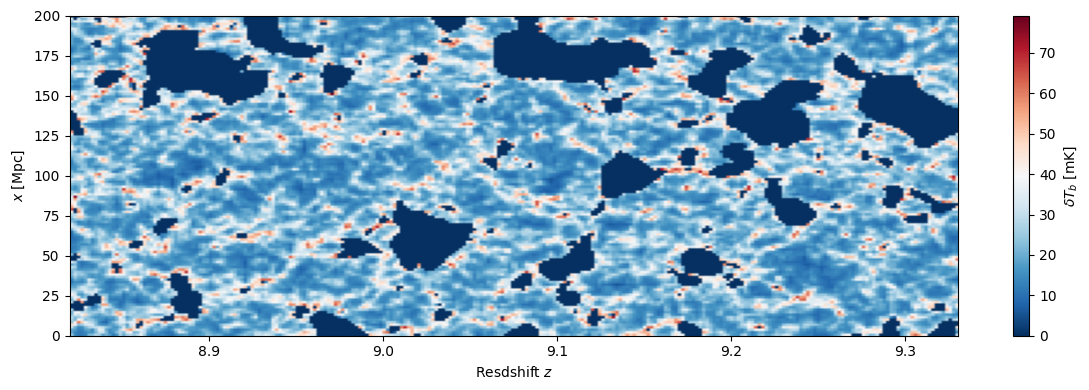

In [6]:
# Read h5py file for slice of lightcone iz-th redshift and i-th realisation
ix = np.random.randint(ngrid)

with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i, :, ix, :]  # Reads only (nz, n, n), not entire data

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
im = ax.imshow(
    lc,
    extent=(redshifts.min(), redshifts.max(), 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'Resdshift $z$')
ax.set_ylabel(r'$x$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
fig.tight_layout()

## Apply SKA AA* observational effects

This is the procedure also followed in `compute_statistic`.

In [75]:
# SKA obs parameters
obs_time = 1000.  # hours
int_time = 10.  # seconds
total_int_time = 4.  # hours per day
Nant = 512  # number of antennas
declination = -30.0  # declination of the field in degrees
bmax = 2. * units.km  # km

In [ ]:
# pick frequency slices for plots
iz = 12  # np.random.randint(nfreq)

In [ ]:
# read lightcone
with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][np.random.randint(nrand), ...]
# move los axis to match t2c
lc = np.moveaxis(lc, 0, 2)

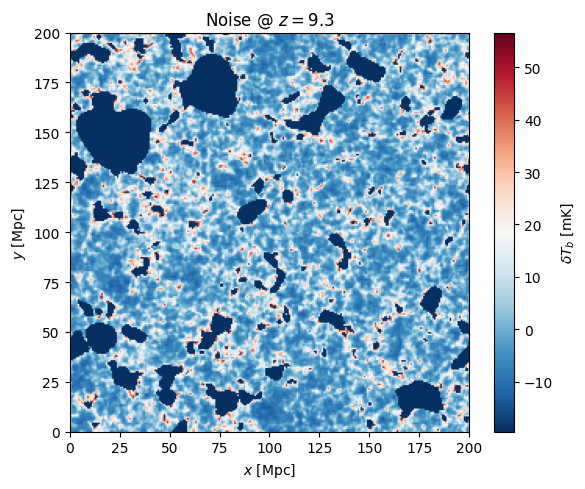

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    t2c.subtract_mean_signal(lc, los_axis=2)[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Noise @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

In [12]:
# generate noise lightcone
noise_lc = t2c.noise_lightcone(
    ncells=ngrid,
    zs=redshifts,
    obs_time=obs_time,
    total_int_time=total_int_time,
    int_time=int_time,
    declination=declination,
    N_ant=Nant,
    subarray_type="AAstar",
    boxsize=box_length,
    verbose=False,
    save_uvmap=ddir+'uvmap_AAstar.h5',  # save uv coverage to re-use for each realisation
    n_jobs=1,
)  # third axis is line of sight

Creating the uv maps.
1/128 | z=9.330
2/128 | z=9.326
3/128 | z=9.322
4/128 | z=9.318
5/128 | z=9.313
6/128 | z=9.309
7/128 | z=9.305
8/128 | z=9.301
9/128 | z=9.297
10/128 | z=9.292
11/128 | z=9.288
12/128 | z=9.284
13/128 | z=9.280
14/128 | z=9.276
15/128 | z=9.271
16/128 | z=9.267
17/128 | z=9.263
18/128 | z=9.259
19/128 | z=9.255
20/128 | z=9.251
21/128 | z=9.246
22/128 | z=9.242
23/128 | z=9.238
24/128 | z=9.234
25/128 | z=9.230
26/128 | z=9.226
27/128 | z=9.222
28/128 | z=9.217
29/128 | z=9.213
30/128 | z=9.209
31/128 | z=9.205
32/128 | z=9.201
33/128 | z=9.197
34/128 | z=9.193
35/128 | z=9.189
36/128 | z=9.184
37/128 | z=9.180
38/128 | z=9.176
39/128 | z=9.172
40/128 | z=9.168
41/128 | z=9.164
42/128 | z=9.160
43/128 | z=9.156
44/128 | z=9.152
45/128 | z=9.148
46/128 | z=9.144
47/128 | z=9.140
48/128 | z=9.135
49/128 | z=9.131
50/128 | z=9.127
51/128 | z=9.123
52/128 | z=9.119
53/128 | z=9.115
54/128 | z=9.111
55/128 | z=9.107
56/128 | z=9.103
57/128 | z=9.099
58/128 | z=9.095
5

In [87]:
print(np.std(lc), np.std(noise_lc))

13.220881390656988 19901.235855725397


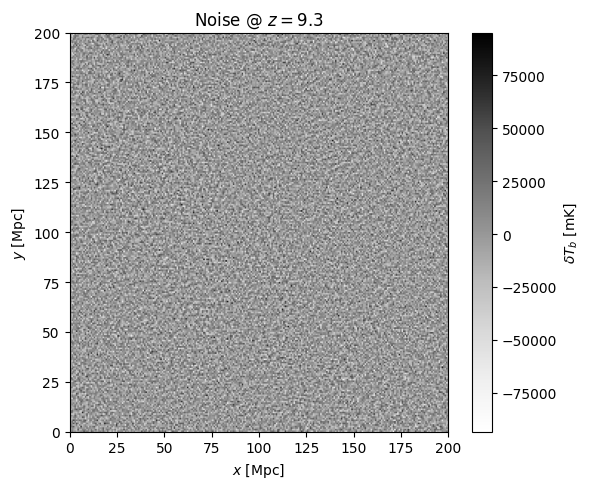

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    noise_lc[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='Greys', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Noise @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

In [79]:
# observation = smoothing x ( cosmological signal + noise )
lambdas = (21.*units.cm) * (1. + redshifts)
fwhm_list = 1.22 * lambdas.si/bmax.si
ang_res = (box_length/ngrid) / cos.comoving_distance(redshifts).value
dt_obs = t2c.smooth_lightcone_gauss(
    lightcone=noise_lc + t2c.subtract_mean_signal(lc, los_axis=2),    # Data cube that is to be smoothed
    fwhm = fwhm_list/ang_res,
    nu_axis=2,  # los axis
)

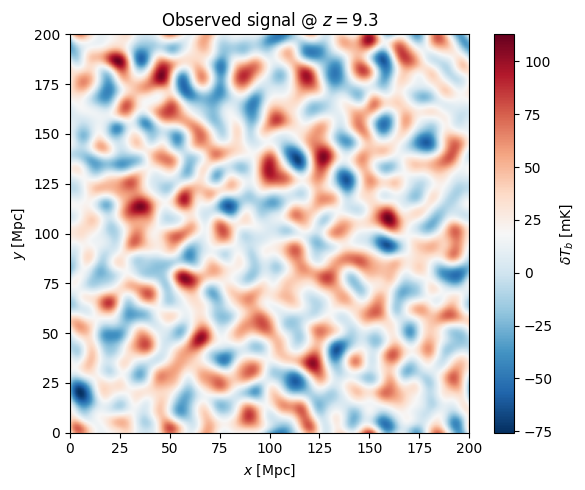

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    dt_obs[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Observed signal @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

## Power spectrum

In [8]:
# Power spectra
nbins = 15
# Fiducial 
ps, ks = t2c.power_spectrum_1d(lc, kbins=15, box_dims=box_length)

Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

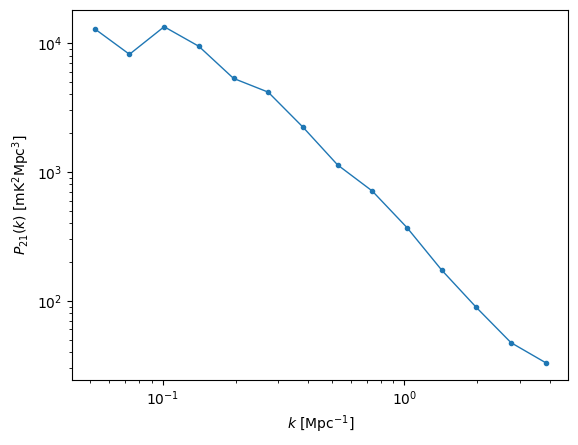

In [9]:
fig, ax = plt.subplots()
ax.loglog(ks, ps, lw=1., marker='.')
ax.set_ylabel(r'$P_{21}(k)$ [mK$^2$Mpc$^3$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')